<a href="https://colab.research.google.com/github/AleksandrRevuka/HW_Data_Science/blob/main/Hw4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
from google.colab import files

uploaded = files.upload()

Saving bikes_rent.csv to bikes_rent.csv


In [86]:
df = pd.read_csv("bikes_rent.csv")

df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,10.486773,2114
727,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,4.656485,3095
728,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,3.725374,1341
729,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,10.505372,1796


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

In [87]:
plt.style.use('ggplot')

season_mapping = {
    1: 'весна',
    2: 'літо',
    3: 'осінь',
    4: 'зима'
}

yr_mapping = {0: 2011, 1: 2012}

mnth_mapping = {
    1: 'січень',
    2: 'лютий',
    3: 'березень',
    4: 'квітень',
    5: 'травень',
    6: 'червень',
    7: 'липень',
    8: 'серпень',
    9: 'вересень',
    10: 'жовтень',
    11: 'листопад',
    12: 'грудень'
}

holiday_mapping = {0: 'немає', 1: 'є'}

weekday_mapping = {
    0: 'понеділок',
    1: 'вівторок',
    2: 'середа',
    3: 'четвер',
    4: 'п\'ятниця',
    5: 'субота',
    6: 'неділя'
}

workingday_mapping = {0: 'неробочий день', 1: 'робочий день'}

weathersit_mapping = {
    1: 'чистий, ясний день',
    2: 'невелика хмарність',
    3: 'помірна хмарність',
    4: 'ливень, туман'
}

Середня кількість прокатів в залежності від сезону

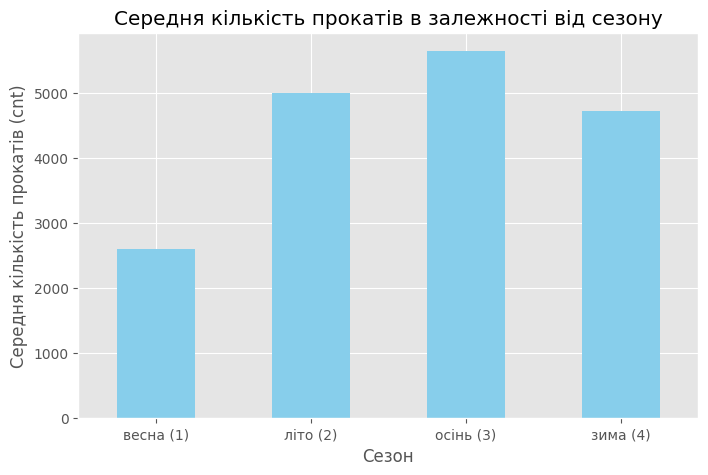

In [88]:
season_cnt_mean = df.groupby('season').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
season_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від сезону')
plt.xlabel('Сезон')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{season_mapping[season]} ({season})' for season in season_cnt_mean.index])
plt.xticks(rotation=0)

plt.show()

Середня кількість прокатів в залежності від року

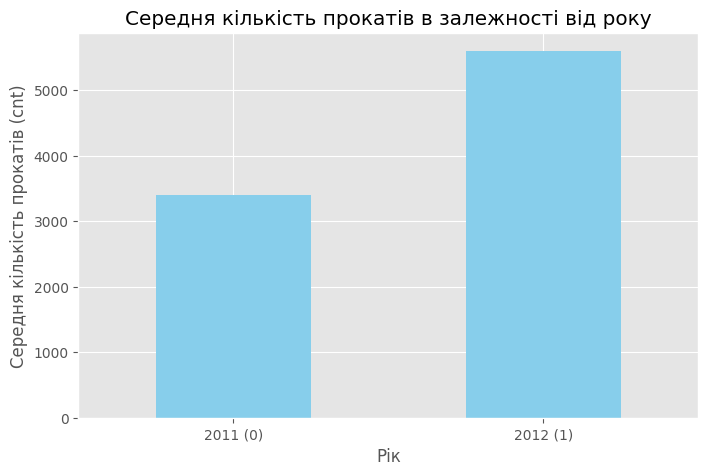

In [6]:
yr_cnt_mean = df.groupby('yr').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
yr_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від року')
plt.xlabel('Рік')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{yr_mapping[yr]} ({yr})' for yr in yr_cnt_mean.index])
plt.xticks(rotation=0)

plt.show()

Середня кількість прокатів в залежності від місяця

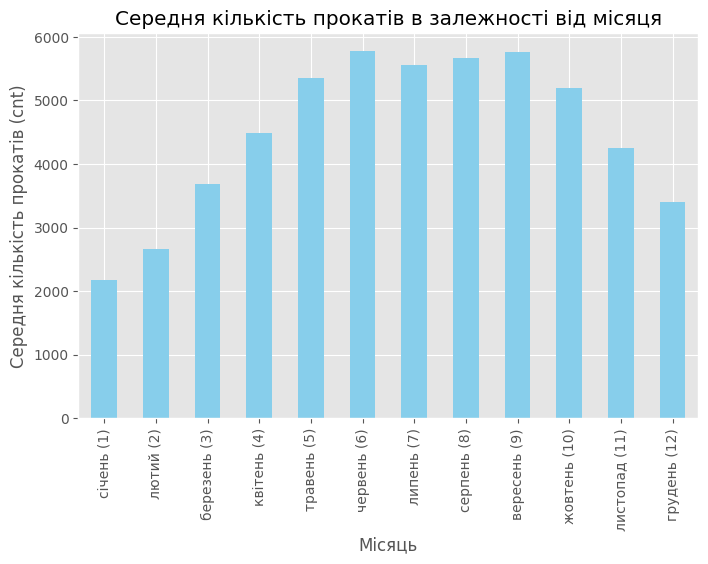

In [7]:
mnth_cnt_mean = df.groupby('mnth').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
mnth_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від місяця')
plt.xlabel('Місяць')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{mnth_mapping[mnth]} ({mnth})' for mnth in mnth_cnt_mean.index])
plt.xticks(rotation=90)

plt.show()

Середня кількість прокатів в залежності від праздників

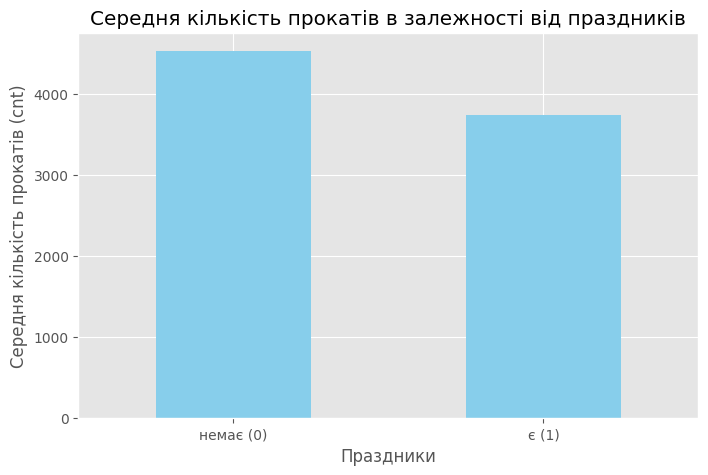

In [8]:
holiday_cnt_mean = df.groupby('holiday').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
holiday_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від праздників')
plt.xlabel('Праздники')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{holiday_mapping[holiday]} ({holiday})' for holiday in holiday_cnt_mean.index])
plt.xticks(rotation=0)

plt.show()

Середня кількість прокатів в залежності від дня неділі

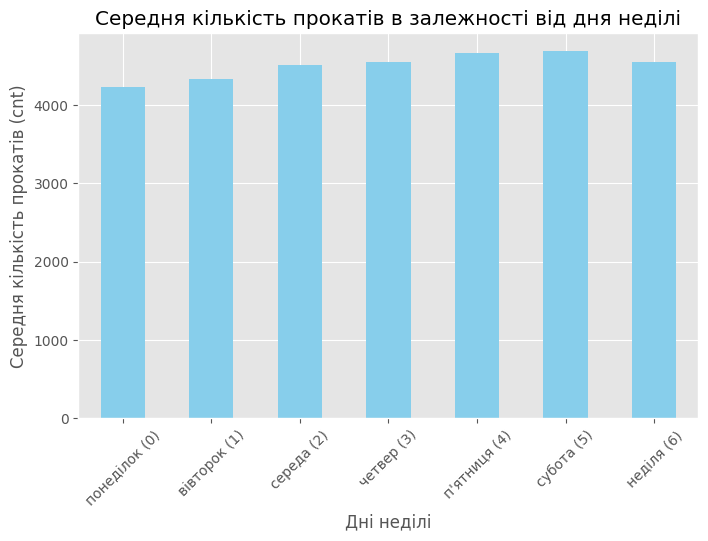

In [9]:
weekday_cnt_mean = df.groupby('weekday').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
weekday_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від дня неділі')
plt.xlabel('Дні неділі')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{weekday_mapping[weekday]} ({weekday})' for weekday in weekday_cnt_mean.index])
plt.xticks(rotation=45)

plt.show()

Середня кількість прокатів в залежності від робочих днів

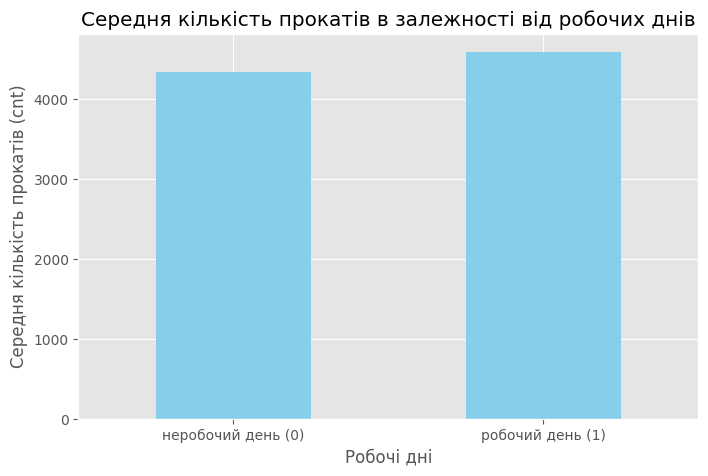

In [10]:
workingday_cnt_mean = df.groupby('workingday').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
workingday_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від робочих днів')
plt.xlabel('Робочі дні')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{workingday_mapping[workingday]} ({workingday})' for workingday in workingday_cnt_mean.index])
plt.xticks(rotation=0)

plt.show()

Середня кількість прокатів в залежності від погоди

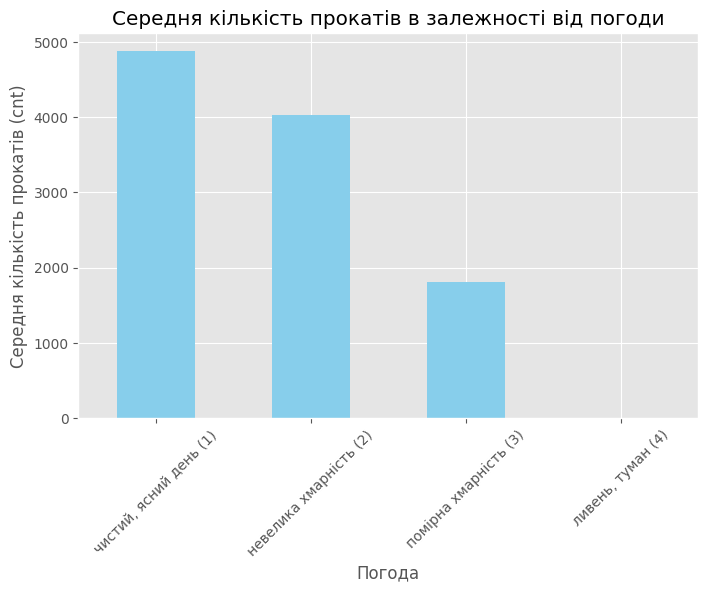

In [11]:
if 4 not in df['weathersit'].unique():
  df = pd.concat([df, pd.DataFrame([{'weathersit': 4, 'cnt': 0}])], ignore_index=True)

weathersit_cnt_mean = df.groupby('weathersit').mean(numeric_only=True)['cnt']

fig, ax = plt.subplots(figsize=(8, 5))
weathersit_cnt_mean.plot(kind='bar', color='skyblue', ax=ax)

plt.title('Середня кількість прокатів в залежності від погоди')
plt.xlabel('Погода')
plt.ylabel('Середня кількість прокатів (cnt)')

ax.set_xticklabels([f'{weathersit_mapping[weathersit]} ({weathersit})' for weathersit in weathersit_cnt_mean.index])
plt.xticks(rotation=45)

plt.show()

df = df.drop(df.index[-1])

Залежність кількості прокатів від температури

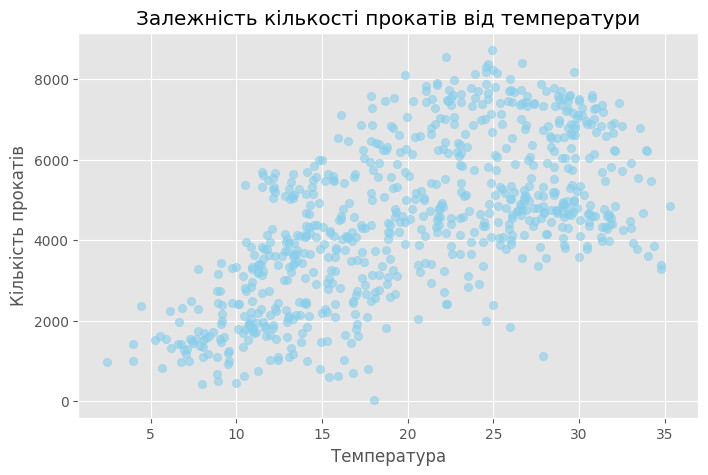

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(df['temp'], df['cnt'], color='skyblue', alpha=0.6)

plt.title('Залежність кількості прокатів від температури')
plt.xlabel('Температура')
plt.ylabel('Кількість прокатів')

plt.show()

Залежність кількості прокатів від температури по відчуттю

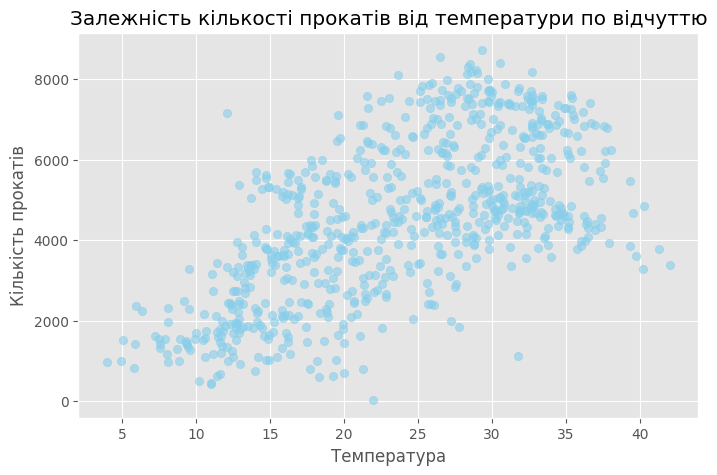

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(df['atemp'], df['cnt'], color='skyblue', alpha=0.6)

plt.title('Залежність кількості прокатів від температури по відчуттю')
plt.xlabel('Температура')
plt.ylabel('Кількість прокатів')

plt.show()

Залежність кількості прокатів від вологості

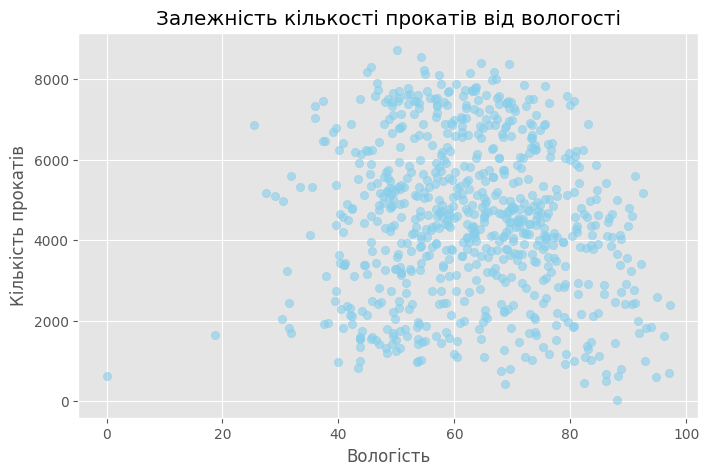

In [14]:
plt.figure(figsize=(8, 5))
plt.scatter(df['hum'], df['cnt'], color='skyblue', alpha=0.6)

plt.title('Залежність кількості прокатів від вологості')
plt.xlabel('Вологість')
plt.ylabel('Кількість прокатів')

plt.show()

Залежність кількості прокатів від швидкості вітру (mph)

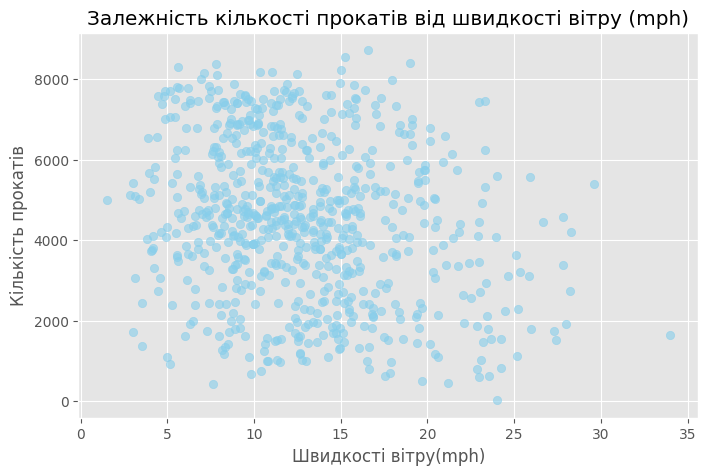

In [15]:
plt.figure(figsize=(8, 5))
plt.scatter(df['windspeed(mph)'], df['cnt'], color='skyblue', alpha=0.6)

plt.title('Залежність кількості прокатів від швидкості вітру (mph)')
plt.xlabel('Швидкості вітру(mph)')
plt.ylabel('Кількість прокатів')

plt.show()

Залежність кількості прокатів від швидкості вітру (ms)

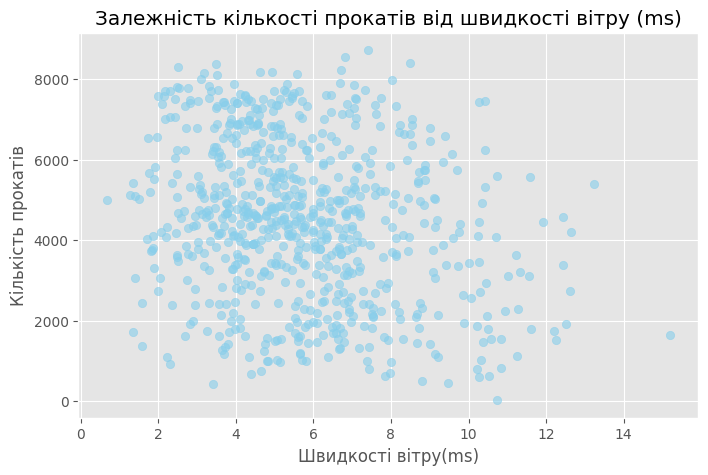

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(df['windspeed(ms)'], df['cnt'], color='skyblue', alpha=0.6)

plt.title('Залежність кількості прокатів від швидкості вітру (ms)')
plt.xlabel('Швидкості вітру(ms)')
plt.ylabel('Кількість прокатів')

plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно.

Відповідь:
1. Лінійне збільшення: З січня до червня є постійне збільшення кількості прокатів.

Постійність: З липня до вересня кількість прокатів залишається постійною.

Лінійне зменшення: З вересня до грудня кількість прокатів лінійно зменшується.

2. Від температури та температури по відчуттю.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [89]:
features = df.iloc[:, :-1]
target = df.iloc[:, -1]

correlations = features.corrwith(target)

print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

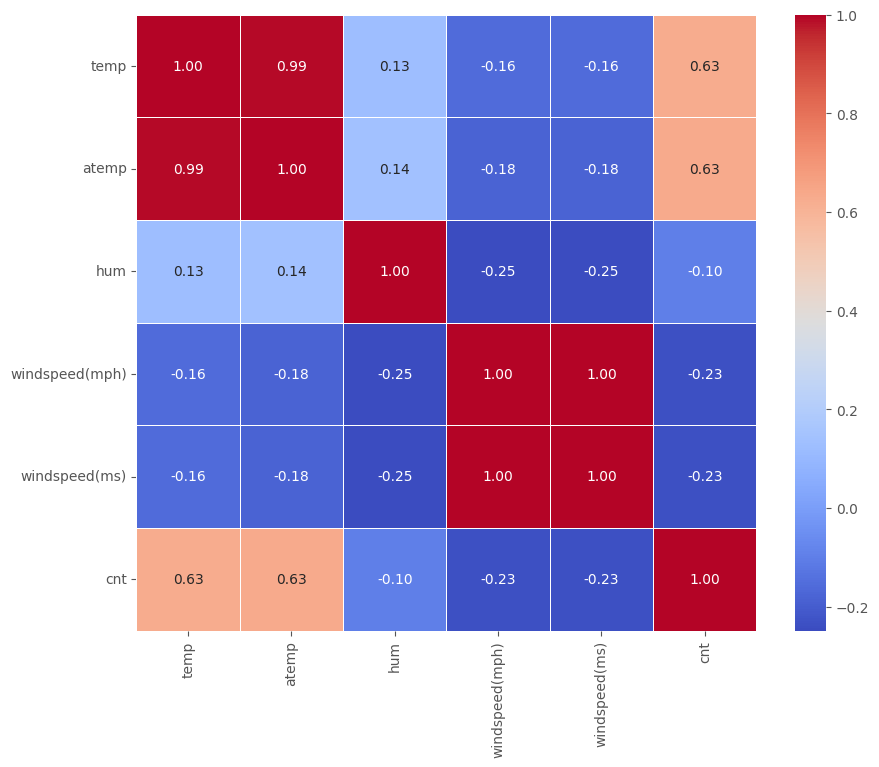

In [90]:
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

subset_data = df[selected_features]

correlation_matrix = subset_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [43]:
feature_means = df.mean()
print(feature_means)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [44]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [45]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [46]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [47]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

weights = list(zip(df.columns[:-1], linear_regressor.coef_))
for feature, weight in weights:
    print(f"{feature}: {weight}")

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [48]:
from sklearn.linear_model import Lasso, Ridge

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)

lasso_weights = list(zip(df.columns[:-1], lasso_regressor.coef_))
print("Lasso weights:")
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")

Lasso weights:
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [49]:
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)

ridge_weights = list(zip(df.columns[:-1], ridge_regressor.coef_))
print("Ridge weights:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")

Ridge weights:
season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [50]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Lasso weights for different alphas:")
print(coefs_lasso)

print("\nRidge weights for different alphas:")
print(coefs_ridge)

Lasso weights for different alphas:
[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1

Проанализируйте динамику весов при увеличении параметра регуляризации:

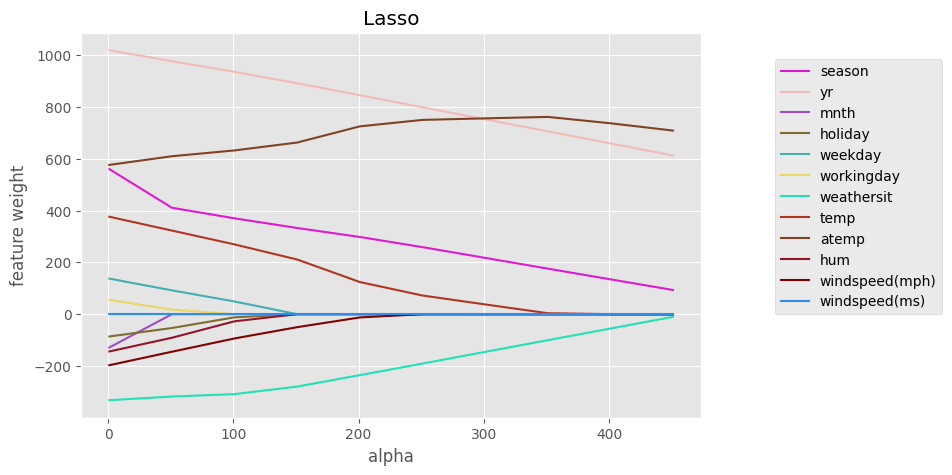

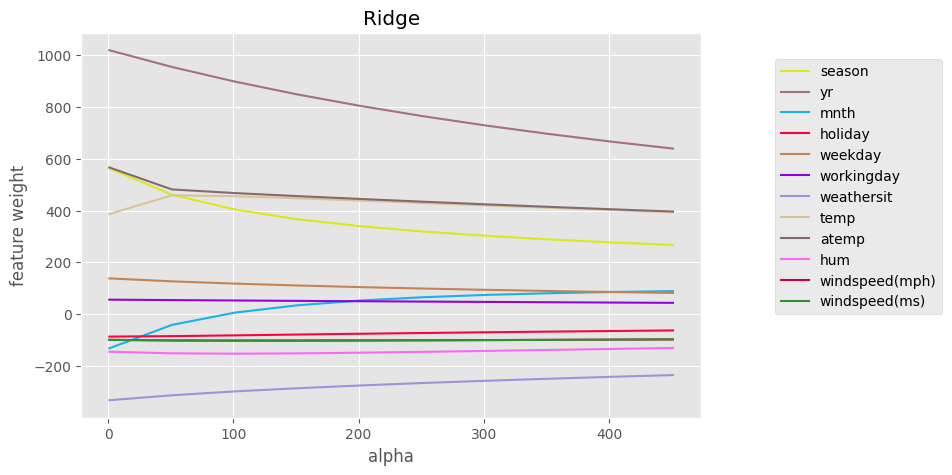

In [51]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?

Відповідь: Lasso

1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.

Відповідь:
Чим більше значення alpha, тим сильніша регуляризація, і вона прагне обнулити ваги більшості ознак.
Це відбувається тому, що у функціоналі втрат, що оптимізується при навчанні лінійної моделі з Lasso, використовується сума абсолютних значень ваг. Коли α дуже велике, оптимізація прагне мінімізувати як помилку передбачення, так і величину суми абсолютних значень вагів.

1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.

Відповідь: Так, це можна стверджувати. Ridge штрафує великі ваги, але не обнулює їх.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

Відповідь: Lasso зазвичай більше підходить для відбору неінформативних ознак. Це з тим, що Lasso має властивість обнулювати ваги деяких ознак, роблячи їх неактивними моделі. Таким чином, Lasso може призвести до розріджених моделей, де лише невелика кількість ознак залишається значущою.

З іншого боку, Ridge штрафує великі ваги, але не обнулює їх. Це означає, що всі ознаки залишаться в моделі, але з більш збалансованою вагою.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [73]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x, y = zip(*data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(linestyle='--')
    plt.show()

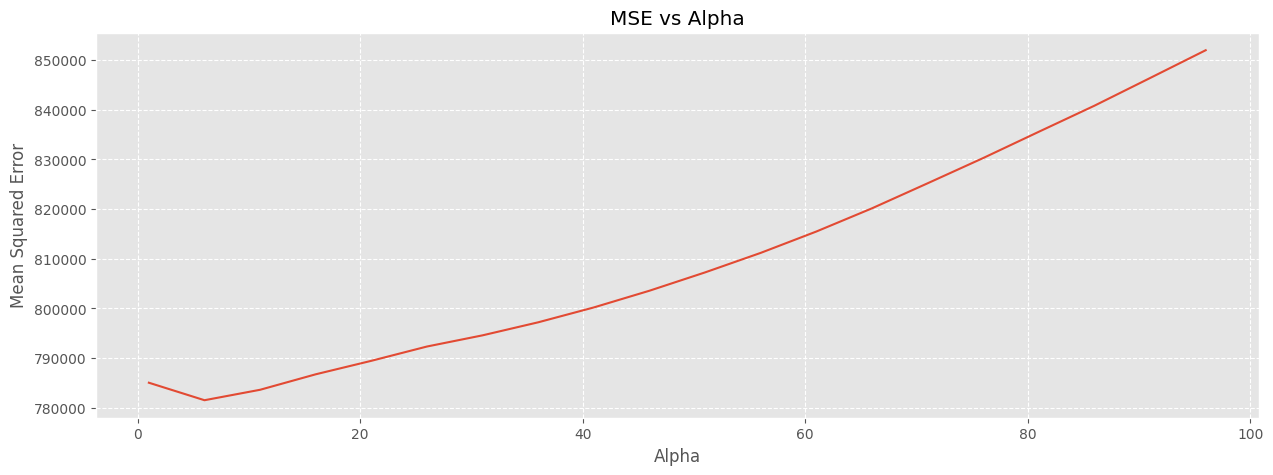

Выбранное alpha: 6
season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


In [74]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)

regressor.fit(X, y)

alphas_values = regressor.alphas_
mse_values = np.mean(regressor.mse_path_, axis=1)

plot_data = list(zip(alphas_values, mse_values))
create_plot(plot_data, "MSE vs Alpha", "Alpha", "Mean Squared Error")

print("Выбранное alpha:", regressor.alpha_)

coefficients = list(zip(features, regressor.coef_))
for feature, coef in coefficients:
    print(f"{feature}: {coef}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Значения alpha, соответствующие минимумам MSE на каждом разбиении: [ 6  1 51]


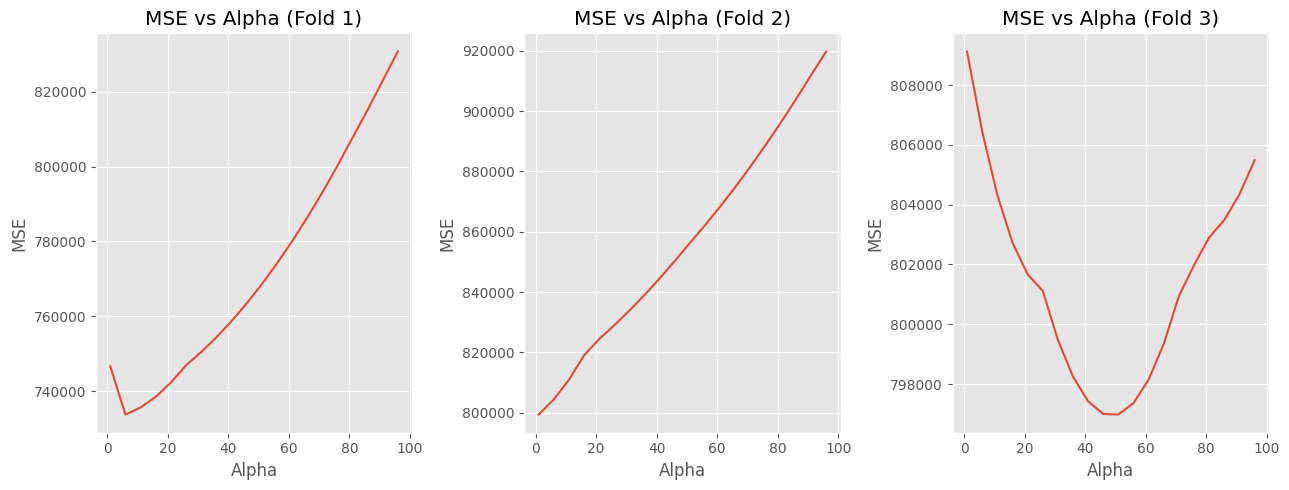

In [84]:
min_mse_indexes = np.argmin(regressor.mse_path_, axis=0)

min_alpha_values = regressor.alphas_[min_mse_indexes]
print("Значения alpha, соответствующие минимумам MSE на каждом разбиении:", min_alpha_values)


plt.figure(figsize=(13, 5))

for i in range(regressor.mse_path_.shape[1]):
    plt.subplot(1, 3, i + 1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i])
    plt.title(f'MSE vs Alpha (Fold {i + 1})')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')

plt.tight_layout()
plt.show()

In [80]:
min_mse_indexes = np.argmin(regressor.mse_path_, axis=0)

min_alpha_values = regressor.alphas_[min_mse_indexes]
min_mse_values = np.min(regressor.mse_path_, axis=0)

print("Alphas with minimum MSE:")
for alpha, mse in zip(min_alpha_values, min_mse_values):
    print(f"Alpha = {alpha}, MSE = {mse}")

Alphas with minimum MSE:
Alpha = 6, MSE = 733725.7604052249
Alpha = 1, MSE = 799433.1673691692
Alpha = 51, MSE = 796979.8955193626


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

In [96]:
print("Выбранное alpha:", regressor.alpha_)

coefficients = list(zip(df.columns[:-1], regressor.coef_))

for feature, coef in coefficients:
    print(f"{feature}: {coef}")

top_features = sorted(coefficients, key=lambda x: -abs(x[1]))[:4]


print("\nTop 4 features with highest positive coefficients:")
for feature, coef in top_features:
    print(f"{feature}: {coef}")

Выбранное alpha: 6
season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08

Top 4 features with highest positive coefficients:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535
temp: 370.67985503003405


Лінійна залежність є. Ні не логічно стверджувати з точки зору здорового глузду.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [99]:
top_negative_features = sorted(coefficients, key=lambda x: x[1])[:3]

print("\nTop 3 features with highest negative coefficients:")
for feature, coef in top_negative_features:
    print(f"{feature}: {coef}")


Top 4 features with highest negative coefficients:
weathersit: -330.5598567399817
windspeed(mph): -191.77140847135036
hum: -140.00740550068844


Так зворотня залежність є. Так логічно це стверджувать.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [101]:
top_negative_features = [item for item in sorted(coefficients, key=lambda x: x[1]) if abs(item[1]) < 1e-3]

print("\nFeatures with coefficients close to zero (< 1e-3):")
for feature, coef in top_negative_features:
    print(f"{feature}: {coef}")


Features with coefficients close to zero (< 1e-3):
windspeed(ms): -2.6854702314758792e-08


Виключила із моделі томущо цей параметр сильно корилює з іншим параметром, а в нашому випадку це один і той же параметр тільки в різних одиницях вимірювання. Да він ніяк не впливає на оренду велосипедів.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.